# 目的

In [1]:
EXP_NAME = "e011_tar_enc"

In [2]:
import polars as pl
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import lightgbm as lgb

import seaborn as sns

In [3]:
pl.__version__

'1.17.1'

In [4]:
lgb.__version__

'4.5.0'

In [5]:
train = pd.read_csv("../data/train.csv") 
test = pd.read_csv("../data/test.csv")
monster = pd.read_csv("../data/monster.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")

In [6]:
test

,Team1,Team2
0,shu421 & YuYagi,kami & T88
1,shu421 & YuYagi,kami & RYUSHI
2,shu421 & YuYagi,kami & tattaka
3,shu421 & YuYagi,Kohecchi & T88
4,shu421 & YuYagi,Kohecchi & RYUSHI
...,...,...
6163,chumajin & NSK,Kinosuke & tattaka
6164,chumajin & NSK,K.T. & tattaka
6165,Kinosuke & K.T.,tattaka & NSK
6166,Kinosuke & tattaka,K.T. & NSK


In [7]:
train.head(100).to_csv("train_head_100.csv", index=False)

# 特徴量生成

In [8]:
train["Team1_1_member"] = train["Team1"].str.split(" & ").apply(lambda x: x[0])
train["Team1_2_member"] = train["Team1"].str.split(" & ").apply(lambda x: x[1])

train["Team2_1_member"] = train["Team2"].str.split(" & ").apply(lambda x: x[0])
train["Team2_2_member"] = train["Team2"].str.split(" & ").apply(lambda x: x[1])

test["Team1_1_member"] = test["Team1"].str.split(" & ").apply(lambda x: x[0])
test["Team1_2_member"] = test["Team1"].str.split(" & ").apply(lambda x: x[1])

test["Team2_1_member"] = test["Team2"].str.split(" & ").apply(lambda x: x[0])
test["Team2_2_member"] = test["Team2"].str.split(" & ").apply(lambda x: x[1])

In [9]:
train = (
    train.merge(
        monster.add_suffix("_1_1"),
        how="left",
        left_on="Team1_1_member",
        right_on="monster_name_1_1"
    ).merge(
        monster.add_suffix("_1_2"),
        how="left",
        left_on="Team1_2_member",
        right_on="monster_name_1_2"
    ).merge(
        monster.add_suffix("_2_1"),
        how="left",
        left_on="Team2_1_member",
        right_on="monster_name_2_1"
    ).merge(
        monster.add_suffix("_2_2"),
        how="left",
        left_on="Team2_2_member",
        right_on="monster_name_2_2"
    )
)

In [10]:
test = (
    test.merge(
        monster.add_suffix("_1_1"),
        how="left",
        left_on="Team1_1_member",
        right_on="monster_name_1_1"
    ).merge(
        monster.add_suffix("_1_2"),
        how="left",
        left_on="Team1_2_member",
        right_on="monster_name_1_2"
    ).merge(
        monster.add_suffix("_2_1"),
        how="left",
        left_on="Team2_1_member",
        right_on="monster_name_2_1"
    ).merge(
        monster.add_suffix("_2_2"),
        how="left",
        left_on="Team2_2_member",
        right_on="monster_name_2_2"
    )
)

In [11]:
train.columns

Index(['Team1', 'Team2', 'Team1_win_ratio', 'battle1_winner', 'battle1_log',
       'battle2_winner', 'battle2_log', 'battle3_winner', 'battle3_log',
       'battle4_winner',
       ...
       'skill2_hitrate_2_2', 'skill2_attribute_2_2', 'skill2_attack_type_2_2',
       'skill2_status_effect_chance_2_2', 'skill3_name_2_2',
       'skill3_power_2_2', 'skill3_hitrate_2_2', 'skill3_attribute_2_2',
       'skill3_attack_type_2_2', 'skill3_status_effect_chance_2_2'],
      dtype='object', length=127)

In [12]:
# def sorted_team_1_member(row):
#     value = "__".join(sorted([row["Team1_1_member"], row["Team1_2_member"]]))
#     return value

# def sorted_team_2_member(row):
#     value = "__".join(sorted([row["Team2_1_member"], row["Team2_2_member"]]))
#     return value

# train["sorted_team_1_member"] = train.apply(lambda x :sorted_team_1_member(x), axis=1)
# train["sorted_team_2_member"] = train.apply(lambda x :sorted_team_2_member(x), axis=1)

# test["sorted_team_1_member"] = test.apply(lambda x :sorted_team_1_member(x), axis=1)
# test["sorted_team_2_member"] = test.apply(lambda x :sorted_team_2_member(x), axis=1)

In [13]:
train = pl.from_pandas(train)
test = pl.from_pandas(test)

In [14]:
USE_COL = ["Team1_1_member", "Team1_2_member", "Team2_1_member", "Team2_2_member"]
USE_COL += [col + "_1_1" for col in monster.columns.tolist() if col not in ("description", "monster_name")]
USE_COL += [col + "_1_2" for col in monster.columns.tolist() if col not in ("description", "monster_name")]
USE_COL += [col + "_2_1" for col in monster.columns.tolist() if col not in ("description", "monster_name")]
USE_COL += [col + "_2_2" for col in monster.columns.tolist() if col not in ("description", "monster_name")]
# USE_COL += ["sorted_team_1_member", "sorted_team_2_member"]

CATEGORICAL_FEATURE = [
    "Team1_1_member",
    "Team1_2_member",
    "Team2_1_member",
    "Team2_2_member",
    "monster_type_1_1",
    "monster_type_1_2",
    "monster_type_2_1",
    "monster_type_2_2",
    "skill1_attribute_1_1",
    "skill1_attribute_1_2",
    "skill1_attribute_2_1",
    "skill1_attribute_2_2",
    "skill2_attribute_1_1",
    "skill2_attribute_1_2",
    "skill2_attribute_2_1",
    "skill2_attribute_2_2",
    "skill3_attribute_1_1",
    "skill3_attribute_1_2",
    "skill3_attribute_2_1",
    "skill3_attribute_2_2",
    "skill1_name_1_1",
    "skill1_name_1_2",
    "skill1_name_2_1",
    "skill1_name_2_2",
    "skill1_attack_type_1_1",
    "skill1_attack_type_1_2",
    "skill1_attack_type_2_1",
    "skill1_attack_type_2_2",
    "skill2_name_1_1",
    "skill2_name_1_2",
    "skill2_name_2_1",
    "skill2_name_2_2",
    "skill2_attack_type_1_1",
    "skill2_attack_type_1_2",
    "skill2_attack_type_2_1",
    "skill2_attack_type_2_2",
    "skill3_name_1_1",
    "skill3_name_1_2",
    "skill3_name_2_1",
    "skill3_name_2_2",
    "skill3_attack_type_1_1",
    "skill3_attack_type_1_2",
    "skill3_attack_type_2_1",
    "skill3_attack_type_2_2",
    # "sorted_team_1_member",
    # "sorted_team_2_member"
]
TARGET_COL = "Team1_win_ratio"
FOLD_NUM = 5
SEED = 33

In [15]:
# Categorical型への変換
train = train.with_columns(pl.col(CATEGORICAL_FEATURE).cast(pl.Categorical))
test = test.with_columns(pl.col(CATEGORICAL_FEATURE).cast(pl.Categorical))

In [16]:
# Foldの作成
fold_arr = np.zeros(train.height)
fold = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)

for idx, (_, val_idx) in enumerate(fold.split(train)):
    fold_arr[val_idx] = idx

train = train.with_columns(pl.Series(fold_arr).cast(pl.Int64).alias("fold"))

# Target Encoding

In [17]:
train = train.to_pandas()
test = test.to_pandas()

results = []
for fold in range(FOLD_NUM):
    train_fold = train[train["fold"] == fold]

    # Team1_1_member
    tar_enc = train_fold.groupby("Team1_1_member")["Team1_win_ratio"].mean()
    train_fold = train_fold.join(tar_enc, on="Team1_1_member", how="left", rsuffix="_tar_enc_1_1")
    
    # Team1_2_member
    tar_enc = train_fold.groupby("Team1_2_member")["Team1_win_ratio"].mean()
    train_fold = train_fold.join(tar_enc, on="Team1_2_member", how="left", rsuffix="_tar_enc_1_2")

    # Team2_1_member
    tar_enc = train_fold.groupby("Team2_1_member")["Team1_win_ratio"].mean()
    train_fold = train_fold.join(tar_enc, on="Team2_1_member", how="left", rsuffix="_tar_enc_2_1")

    # Team2_2_member
    tar_enc = train_fold.groupby("Team2_2_member")["Team1_win_ratio"].mean()
    train_fold = train_fold.join(tar_enc, on="Team2_2_member", how="left", rsuffix="_tar_enc_2_2")

    results.append(train_fold)

train = pd.concat(results).sort_index()

In [ ]:
# testに対するTarget Encoding
# Team1_1_member
tar_enc = train.groupby("Team1_1_member")["Team1_win_ratio"].mean()
test = test.join(tar_enc, on="Team1_1_member", how="left", rsuffix="_tar_enc_1_1")

# Team1_2_member
tar_enc = train.groupby("Team1_2_member")["Team1_win_ratio"].mean()
test = test.join(tar_enc, on="Team1_2_member", how="left", rsuffix="_tar_enc_1_2")

# Team2_1_member
tar_enc = train.groupby("Team2_1_member")["Team1_win_ratio"].mean()
test = test.join(tar_enc, on="Team2_1_member", how="left", rsuffix="_tar_enc_2_1")

# Team2_2_member
tar_enc = train.groupby("Team2_2_member")["Team1_win_ratio"].mean()
test = test.join(tar_enc, on="Team2_2_member", how="left", rsuffix="_tar_enc_2_2")

In [22]:
test = test.join(tar_enc, on="Team1_1_member", how="left", rsuffix="_tar_enc_1_1")

In [23]:
test

,Team1,Team2,Team1_1_member,Team1_2_member,Team2_1_member,Team2_2_member,monster_name_1_1,description_1_1,monster_type_1_1,attack_1_1,...,skill3_power_2_2,skill3_hitrate_2_2,skill3_attribute_2_2,skill3_attack_type_2_2,skill3_status_effect_chance_2_2,Team1_win_ratio,Team1_win_ratio_tar_enc_1_2,Team1_win_ratio_tar_enc_2_1,Team1_win_ratio_tar_enc_2_2,Team1_win_ratio_tar_enc_1_1
0,shu421 & YuYagi,kami & T88,shu421,YuYagi,kami,T88,shu421,モンスター「shu421」は、まるで炎の精霊のような存在で、周囲を包む温かな光と熱を持ってい...,火,85,...,60.0,60,火,速攻型,0.0,0.549963,0.626374,0.712923,NaN,NaN
1,shu421 & YuYagi,kami & RYUSHI,shu421,YuYagi,kami,RYUSHI,shu421,モンスター「shu421」は、まるで炎の精霊のような存在で、周囲を包む温かな光と熱を持ってい...,火,85,...,108.0,60,水,遅攻型,0.1,0.549963,0.626374,0.712923,NaN,NaN
2,shu421 & YuYagi,kami & tattaka,shu421,YuYagi,kami,tattaka,shu421,モンスター「shu421」は、まるで炎の精霊のような存在で、周囲を包む温かな光と熱を持ってい...,火,85,...,120.0,60,草,遅攻型,0.1,0.549963,0.626374,0.712923,NaN,NaN
3,shu421 & YuYagi,Kohecchi & T88,shu421,YuYagi,Kohecchi,T88,shu421,モンスター「shu421」は、まるで炎の精霊のような存在で、周囲を包む温かな光と熱を持ってい...,火,85,...,60.0,60,火,速攻型,0.0,0.549963,0.626374,0.457870,NaN,NaN
4,shu421 & YuYagi,Kohecchi & RYUSHI,shu421,YuYagi,Kohecchi,RYUSHI,shu421,モンスター「shu421」は、まるで炎の精霊のような存在で、周囲を包む温かな光と熱を持ってい...,火,85,...,108.0,60,水,遅攻型,0.1,0.549963,0.626374,0.457870,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6163,chumajin & NSK,Kinosuke & tattaka,chumajin,NSK,Kinosuke,tattaka,chumajin,chumajinは、優雅にそよぐ葉を持つ独特な存在で、発芽したての小さい苗のように愛らしい姿...,草,78,...,120.0,60,草,遅攻型,0.1,0.466667,0.828791,0.378022,NaN,0.586991
6164,chumajin & NSK,K.T. & tattaka,chumajin,NSK,K.T.,tattaka,chumajin,chumajinは、優雅にそよぐ葉を持つ独特な存在で、発芽したての小さい苗のように愛らしい姿...,草,78,...,120.0,60,草,遅攻型,0.1,0.466667,0.828791,0.185714,NaN,0.586991
6165,Kinosuke & K.T.,tattaka & NSK,Kinosuke,K.T.,tattaka,NSK,Kinosuke,Kinosukeは、神秘的な森の深部に生息し、周囲の植物と一体化することで知られるモンスター...,草,78,...,96.0,82,草,遅攻型,0.0,NaN,0.650769,NaN,0.265495,0.611676
6166,Kinosuke & tattaka,K.T. & NSK,Kinosuke,tattaka,K.T.,NSK,Kinosuke,Kinosukeは、神秘的な森の深部に生息し、周囲の植物と一体化することで知られるモンスター...,草,78,...,96.0,82,草,遅攻型,0.0,NaN,NaN,0.185714,0.265495,0.611676


In [33]:
test = test.with_columns(pl.col(CATEGORICAL_FEATURE).cast(pl.Categorical))

In [24]:
train = pl.from_pandas(train)
test = pl.from_pandas(test)

In [25]:
USE_COL += [
    'Team1_win_ratio_tar_enc_1_1',
    'Team1_win_ratio_tar_enc_1_2',
    'Team1_win_ratio_tar_enc_2_1',
    'Team1_win_ratio_tar_enc_2_2'
]

In [26]:
# LightGBMで用いるパラメータを指定
params = {
    "objective": "regression",
    "metric": "rmse",
    "max_depth": -1,
    "min_data_in_leaf": 10,  # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.01,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、-1はFatalなログのみを出力
    "seed": SEED,  # ランダムシードの固定
    "lambda_l1": 0.4,  # 正則化のためのパラメータ
    "lambda_l2": 0.4,  # 正則化のためのパラメータ
}

In [27]:
# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train.filter(pl.col("fold") != fold)
    valid_fold = train.filter(pl.col("fold") == fold)

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.select(USE_COL)
    X_valid = valid_fold.select(USE_COL)
    y_train = train_fold.select(TARGET_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train.to_pandas(), y_train.to_pandas())
    lgb_eval = lgb.Dataset(
        X_valid.to_pandas(), y_valid.to_pandas(), reference=lgb_train
    )

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(
                stopping_rounds=100
            ),  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
            lgb.log_evaluation(100),  # 指定したiteration回数ごとにlogを出力する
        ],
    )

    # モデルを保存
    models.append([fold, model])

Start fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.198253	valid_1's rmse: 0.206198
[200]	training's rmse: 0.160345	valid_1's rmse: 0.171407
[300]	training's rmse: 0.144393	valid_1's rmse: 0.158325
[400]	training's rmse: 0.135675	valid_1's rmse: 0.151632
[500]	training's rmse: 0.129958	valid_1's rmse: 0.148103
[600]	training's rmse: 0.126063	valid_1's rmse: 0.146219
[700]	training's rmse: 0.123047	valid_1's rmse: 0.145039
[800]	training's rmse: 0.120406	valid_1's rmse: 0.144195
[900]	training's rmse: 0.118157	valid_1's rmse: 0.143728
[1000]	training's rmse: 0.116062	valid_1's rmse: 0.143255
[1100]	training's rmse: 0.114113	valid_1's rmse: 0.142956
[1200]	training's rmse: 0.112304	valid_1's rmse: 0.142874
Early stopping, best iteration is:
[1148]	training's rmse: 0.113242	valid_1's rmse: 0.142815
Start fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.198898	valid_1's rmse: 0.200799
[200]	trainin

In [28]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# foldの値と学習済みモデルを利用し、モデルの評価を行う
for fold, model in models:
    valid_fold = train.filter(pl.col("fold") == fold)

    X_valid = valid_fold.select(USE_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # validデータに対する推論
    y_valid_pred = model.predict(
        X_valid.to_pandas(), num_iteration=model.best_iteration
    )

    score = root_mean_squared_error(y_valid, y_valid_pred)
    print(f"fold {fold} Score: {score}")

    is_valid = train.get_column("fold") == fold
    oof[is_valid] = y_valid_pred

fold 0 Score: 0.14281525559408226
fold 1 Score: 0.14351921969823805
fold 2 Score: 0.14434599560174793
fold 3 Score: 0.14587042140922882
fold 4 Score: 0.15120893717229367


In [29]:
oof_score = root_mean_squared_error(train.get_column(TARGET_COL), oof)
oof_score

0.14558300218249015

<Axes: >

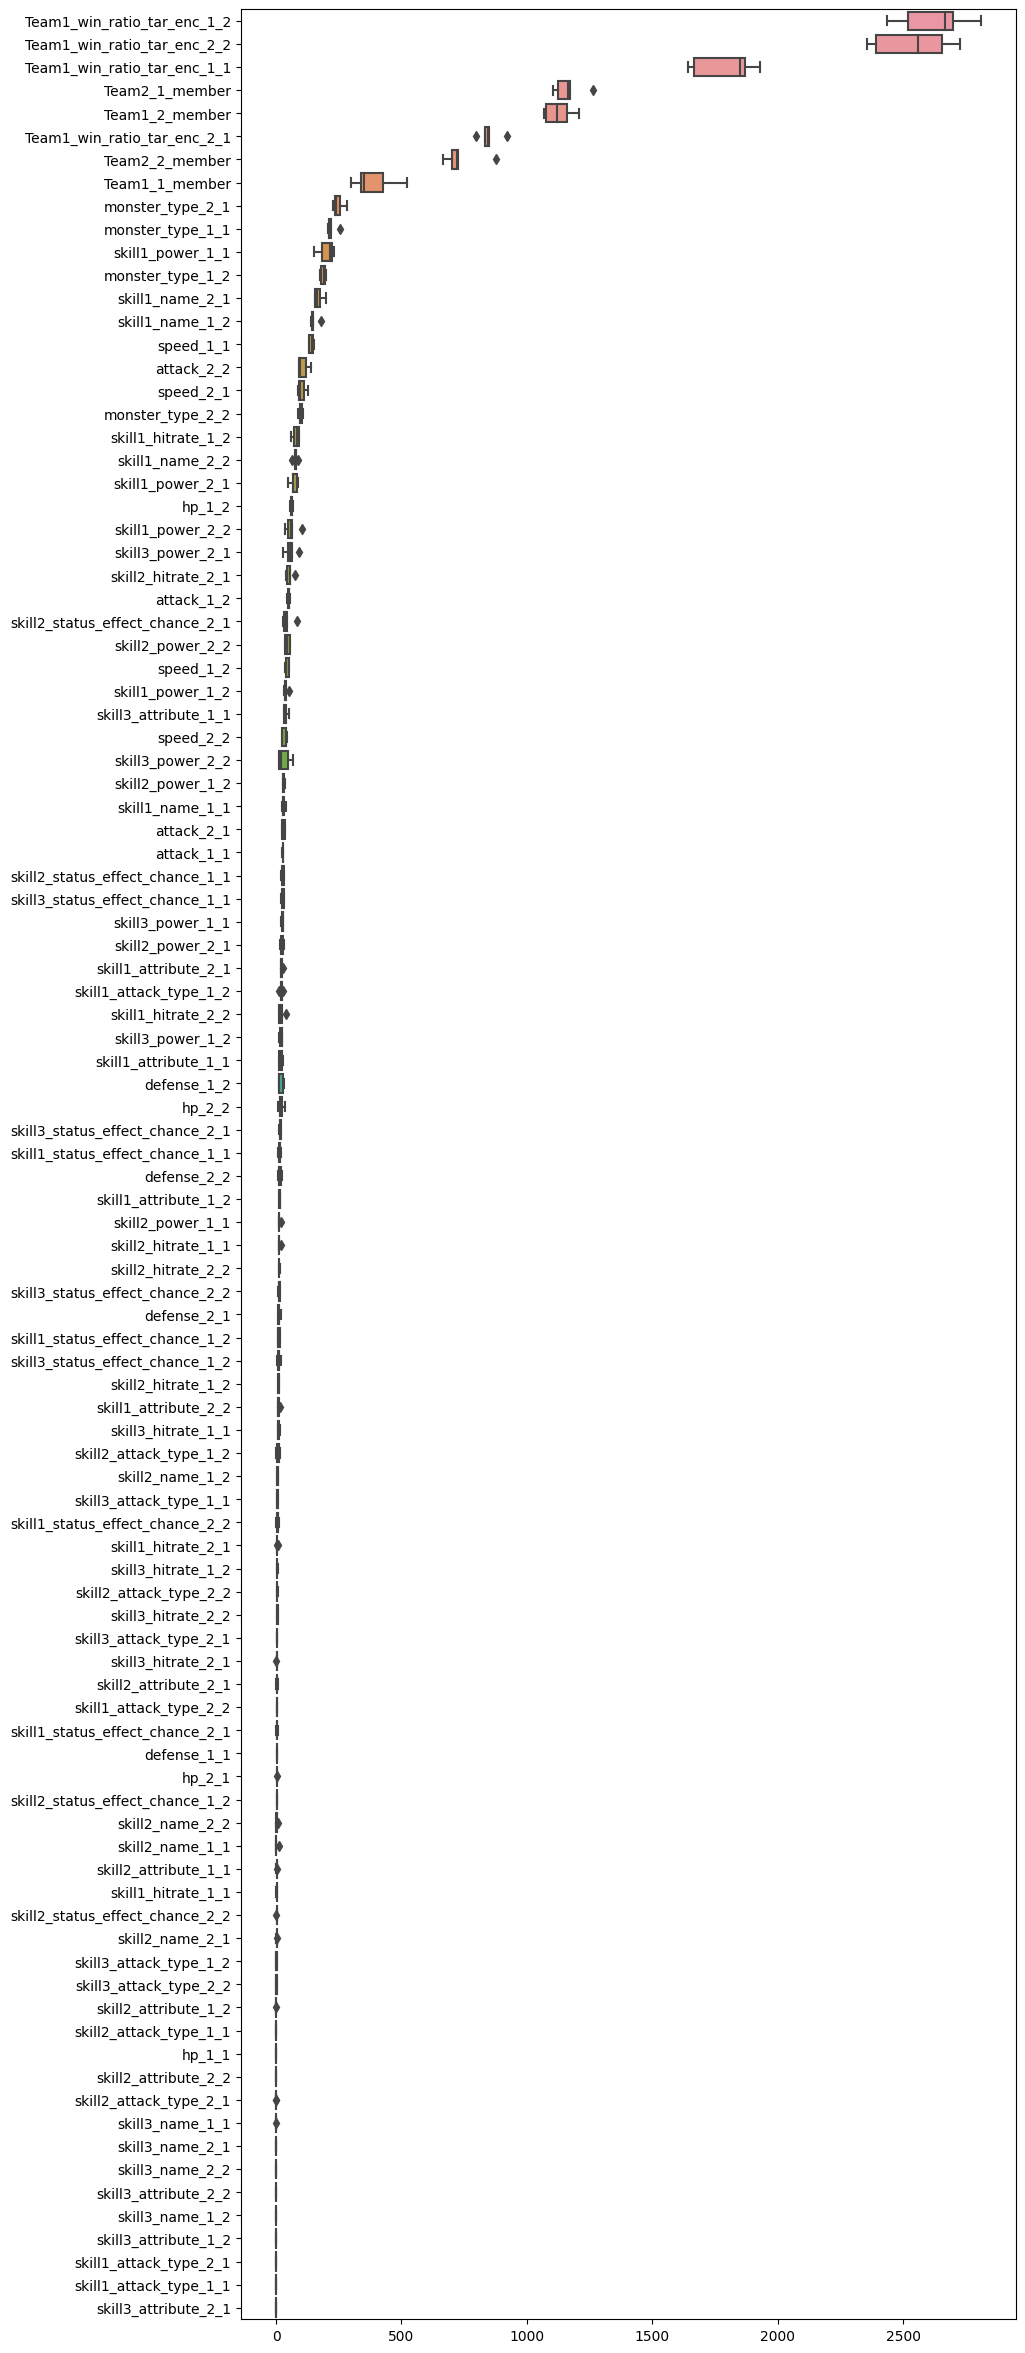

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = [
    model.feature_importance(importance_type="gain") for _, model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=USE_COL)

order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()
plt.figure(figsize=(10, 30))
sns.boxplot(data=feature_importances_df, orient="h", order=order)

In [31]:
test

Team1,Team2,Team1_1_member,Team1_2_member,Team2_1_member,Team2_2_member,monster_name_1_1,description_1_1,monster_type_1_1,attack_1_1,defense_1_1,speed_1_1,hp_1_1,skill1_name_1_1,skill1_power_1_1,skill1_hitrate_1_1,skill1_attribute_1_1,skill1_attack_type_1_1,skill1_status_effect_chance_1_1,skill2_name_1_1,skill2_power_1_1,skill2_hitrate_1_1,skill2_attribute_1_1,skill2_attack_type_1_1,skill2_status_effect_chance_1_1,skill3_name_1_1,skill3_power_1_1,skill3_hitrate_1_1,skill3_attribute_1_1,skill3_attack_type_1_1,skill3_status_effect_chance_1_1,monster_name_1_2,description_1_2,monster_type_1_2,attack_1_2,defense_1_2,speed_1_2,…,skill2_status_effect_chance_2_1,skill3_name_2_1,skill3_power_2_1,skill3_hitrate_2_1,skill3_attribute_2_1,skill3_attack_type_2_1,skill3_status_effect_chance_2_1,monster_name_2_2,description_2_2,monster_type_2_2,attack_2_2,defense_2_2,speed_2_2,hp_2_2,skill1_name_2_2,skill1_power_2_2,skill1_hitrate_2_2,skill1_attribute_2_2,skill1_attack_type_2_2,skill1_status_effect_chance_2_2,skill2_name_2_2,skill2_power_2_2,skill2_hitrate_2_2,skill2_attribute_2_2,skill2_attack_type_2_2,skill2_status_effect_chance_2_2,skill3_name_2_2,skill3_power_2_2,skill3_hitrate_2_2,skill3_attribute_2_2,skill3_attack_type_2_2,skill3_status_effect_chance_2_2,Team1_win_ratio,Team1_win_ratio_tar_enc_1_2,Team1_win_ratio_tar_enc_2_1,Team1_win_ratio_tar_enc_2_2,Team1_win_ratio_tar_enc_1_1
str,str,str,str,str,str,str,str,cat,i64,i64,i64,i64,cat,f64,i64,cat,cat,f64,cat,f64,i64,cat,cat,f64,cat,f64,i64,cat,cat,f64,str,str,cat,i64,i64,i64,…,f64,cat,f64,i64,cat,cat,f64,str,str,cat,i64,i64,i64,i64,cat,f64,i64,cat,cat,f64,cat,f64,i64,cat,cat,f64,cat,f64,i64,cat,cat,f64,f64,f64,f64,f64,f64
"""shu421 & YuYagi""","""kami & T88""","""shu421""","""YuYagi""","""kami""","""T88""","""shu421""","""モンスター「shu421」は、まるで炎の精霊のような存在で、…","""火""",85,75,90,250,"""フレイムストライク""",42.0,85,"""火""","""速攻型""",0.0,"""炎の護り""",50.0,95,"""火""","""普通""",0.0,"""焼尽""",108.0,75,"""火""","""遅攻型""",0.1,"""YuYagi""","""モンスター「YuYagi」は、燃えるような思考力を持つ賢い存…","""火""",82,70,88,…,0.0,"""煉獄の炎""",60.0,60,"""火""","""速攻型""",0.15,"""T88""","""モンスター「T88」は、灼熱の地で生まれた炎が宿る存在です。…","""火""",85,70,77,245,"""灼熱の一撃""",54.0,70,"""火""","""速攻型""",0.2,"""熱波""",90.0,85,"""火""","""遅攻型""",0.0,"""溶解炎""",60.0,60,"""火""","""速攻型""",0.0,0.549963,0.626374,0.712923,null,null
"""shu421 & YuYagi""","""kami & RYUSHI""","""shu421""","""YuYagi""","""kami""","""RYUSHI""","""shu421""","""モンスター「shu421」は、まるで炎の精霊のような存在で、…","""火""",85,75,90,250,"""フレイムストライク""",42.0,85,"""火""","""速攻型""",0.0,"""炎の護り""",50.0,95,"""火""","""普通""",0.0,"""焼尽""",108.0,75,"""火""","""遅攻型""",0.1,"""YuYagi""","""モンスター「YuYagi」は、燃えるような思考力を持つ賢い存…","""火""",82,70,88,…,0.0,"""煉獄の炎""",60.0,60,"""火""","""速攻型""",0.15,"""RYUSHI""","""RYUSHIは、水の流れの如く、幾何学的な模様を持つ美しいモ…","""水""",85,71,92,250,"""流水斬""",45.0,85,"""水""","""速攻型""",0.0,"""冷気の波""",80.0,95,"""水""","""普通""",0.0,"""深海の怒り""",108.0,60,"""水""","""遅攻型""",0.1,0.549963,0.626374,0.712923,null,null
"""shu421 & YuYagi""","""kami & tattaka""","""shu421""","""YuYagi""","""kami""","""tattaka""","""shu421""","""モンスター「shu421」は、まるで炎の精霊のような存在で、…","""火""",85,75,90,250,"""フレイムストライク""",42.0,85,"""火""","""速攻型""",0.0,"""炎の護り""",50.0,95,"""火""","""普通""",0.0,"""焼尽""",108.0,75,"""火""","""遅攻型""",0.1,"""YuYagi""","""モンスター「YuYagi」は、燃えるような思考力を持つ賢い存…","""火""",82,70,88,…,0.0,"""煉獄の炎""",60.0,60,"""火""","""速攻型""",0.15,"""tattaka""","""tattakaは森林深くに生息する神秘的な存在で、他の草属性…","""草""",75,65,82,245,"""リーフストーム""",54.0,70,"""草""","""速攻型""",0.0,"""グリーンバリア""",39.0,85,"""草""","""速攻型""",0.0,"""フラワーブレード""",120.0,60,"""草""","""遅攻型""",0.1,0.549963,0.626374,0.712923,null,null
"""shu421 & YuYagi""","""Kohecchi & T88""","""shu421""","""YuYagi""","""Kohecchi""","""T88""","""shu421""","""モンスター「shu421」は、まるで炎の精霊のような存在で、…","""火""",85,75,90,250,"""フレイムストライク""",42.0,85,"""火""","""速攻型""",0.0,"""炎の護り""",50.0,95,"""火""","""普通""",0.0,"""焼尽""",108.0,75,"""火""","""遅攻型""",0.1,"""YuYagi""","""モンスター「YuYagi」は、燃えるような思考力を持つ賢い存…","""火""",82,70,88,…,0.0,"""光の炎""",30.0,90,"""火""","""速攻型""",0.0,"""T88""

In [34]:
pred = np.array([model.predict(test[USE_COL].to_pandas()) for _, model in models])
pred = np.mean(pred, axis=0)
pred

array([0.51027043, 0.49789408, 0.5530822 , ..., 0.46969969, 0.3028361 ,
       0.65938171])

In [35]:
len(pred)

6168

In [36]:
sample_submission["Team1_win_ratio"] = pred
sample_submission.to_csv(f"../submission/{EXP_NAME}_CV{oof_score:.4f}.csv", index=False)

In [37]:
sample_submission

,Team1_win_ratio,Team1_Team2
0,0.510270,shu421 & YuYagi_kami & T88
1,0.497894,shu421 & YuYagi_kami & RYUSHI
2,0.553082,shu421 & YuYagi_kami & tattaka
3,0.374457,shu421 & YuYagi_Kohecchi & T88
4,0.354799,shu421 & YuYagi_Kohecchi & RYUSHI
...,...,...
6163,0.683715,chumajin & NSK_Kinosuke & tattaka
6164,0.652313,chumajin & NSK_K.T. & tattaka
6165,0.469700,Kinosuke & K.T._tattaka & NSK
6166,0.302836,Kinosuke & tattaka_K.T. & NSK
